In [436]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
import torch
from typing import List

pyro.settings.set(module_local_params=True)
sns.set_style("white")
pyro.set_rng_seed(321) # for reproducibility

## Load and filter data 

We analyze the SciPlex3 dataset from [3], which consists of 188 drug perturbations on three different cancer cell types.

In [4]:
# Load in sciplex3 study data as anndata
anndata = sc.read_h5ad("SrivatsanTrapnell2020_sciplex3_debugged.h5")

# Remove unknown cell types
anndata = anndata[~anndata.obs['cell_type'].isnull()]

# Filter out to only 24hr observations (~90% of the data remains)
anndata = anndata[anndata.obs['time_point'] == 24]

# Restrict to genes in human genome
annot = sc.queries.biomart_annotations(
    "hsapiens", ["ensembl_gene_id", "hgnc_symbol"]
)
annot = annot.dropna()
anndata = anndata[:, anndata.var['ensembl_gene_id'].isin(annot['ensembl_gene_id'].values)]

temp = sc.queries.biomart_annotations(
    "hsapiens", ["ensembl_gene_id", "hgnc_symbol", "description"]
)

# Filter out genes that are expressed in less than 10 cells
sc.pp.filter_genes(anndata, min_cells=10)

# Filter out cells that express less than 200 genes
sc.pp.filter_cells(anndata, min_genes=200)

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/annd

## Data walkthrough

Below we provide some basic summaries and visuals of the data to improve understanding of the underlying dataset.

In [5]:
# the count matrix is # cells x # genes
print(anndata.X.shape)

(679955, 27718)


In [9]:
# For each cell, these are the annotations available
anndata.obs.columns

Index(['cell', 'sample', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W',
       'qval_W', 'top_to_second_best_ratio_W', 'top_oligo_W', 'hash_umis_P',
       'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'top_oligo_P',
       'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'culture_plate',
       'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo',
       'cell_type', 'replicate', 'time_point', 'drug_dose', 'catalog_number',
       'vehicle', 'dose_pattern', 'dose_character', 'dose', 'treatment',
       'pathway_level_1', 'pathway_level_2', 'product_name', 'target',
       'pathway', 'dose_unit', 'celltype', 'disease', 'n_genes'],
      dtype='object')

In [10]:
# In the dataset, there are three different cell types represented.
anndata.obs['cell_type'].value_counts()

cell_type
MCF7    344757
K562    173139
A549    162059
Name: count, dtype: int64

In [18]:
# Each cell goes either is unperturbed (tagged as "Vehicle") or recieves a
# drug perturbation (188 possible choices)
pd.crosstab(
    anndata.obs['product_name'],
    anndata.obs['dose'],
    margins=True
)

dose,0.0,10.0,100.0,1000.0,10000.0,All
product_name,,,,,,
2-Methoxyestradiol (2-MeOE2),0,983,842,953,571,3349
(+)-JQ1,0,909,822,964,890,3585
A-366,0,1088,899,883,994,3864
ABT-737,0,871,802,699,745,3117
AC480 (BMS-599626),0,949,1006,1004,796,3755
...,...,...,...,...,...,...
XAV-939,0,853,1002,1053,813,3721
YM155 (Sepantronium Bromide),0,345,272,183,189,989
ZM 447439,0,891,938,720,705,3254


In [38]:
# For each drug, there are different pathways that are targeted
drug_vs_target = anndata.obs[['target', 'product_name']].drop_duplicates().reset_index(drop=True)
drug_vs_target.head()

,target,product_name
0,Aurora Kinase,TAK-901
1,EGFR,AG-490 (Tyrphostin B42)
2,HDAC,Abexinostat (PCI-24781)
3,DNA alkylator,Busulfan
4,Bcl-2,Obatoclax Mesylate (GX15-070)


In [39]:
# Distribution of the number of drugs that target each of the 87 pathways
# The maximum number of drugs that target a single pathway is 23
drug_vs_target.groupby(by=['target']).size().describe().round(2)

count    87.00
mean      2.17
std       3.27
min       1.00
25%       1.00
50%       1.00
75%       2.00
max      23.00
dtype: float64

## Targeting histone deacetylase inhibitors

Histone deacetylase (HDAC) inhibitors are anti-cancer agents that can induce death, apoptosis, and cell cycle arrest in cancer cells [2]. In the HGNC database, there are 18 genes associated with the histone deacetylase superfamily [4]. We focus on modeling the changes in  expression of these 18 genes in response to drugs targeting the HDAC pathway.

In [58]:
# Different subgroups part of the histone deacetylase family from [4]
sirt = [
    "SIRT1", "SIRT2", "SIRT3", "SIRT4", "SIRT5", "SIRT6", "SIRT7"
]

class_one = [
    "HDAC1", "HDAC2", "HDAC3", "HDAC8"
]

class_two_a = [
    "HDAC4", "HDAC5", "HDAC7", "HDAC9"

]

class_two_b = [
    "HDAC6", "HDAC10"
]

class_four = [
    "HDAC11"
]

hdac_genes = sirt + class_one + class_two_a + class_two_b + class_four
hdac_data = anndata[:, anndata.var.index.isin(hdac_genes)]

### First, we compute some summary statistics to better understand HDAC

In [70]:
# List of drugs that target HDAC pathway
# See Figure 3 in [3] for the clinical trial stage of some of these drugs
drug_vs_target[drug_vs_target.target == 'HDAC']

,target,product_name
2,HDAC,Abexinostat (PCI-24781)
9,HDAC,Tubastatin A HCl
16,HDAC,Divalproex Sodium
27,HDAC,Sodium Phenylbutyrate
28,HDAC,Dacinostat (LAQ824)
40,HDAC,Droxinostat
46,HDAC,Tucidinostat (Chidamide)
48,HDAC,PCI-34051
50,HDAC,Resminostat
62,HDAC,Trichostatin A (TSA)


In [77]:
# We further subset to cells that involve one of these drugs that target HDAC or are unperturbed
hdac_targets_and_control = list(drug_vs_target[drug_vs_target.target == 'HDAC'].product_name.values) + ['Vehicle']
hdac_data = hdac_data[hdac_data.obs['product_name'].isin(hdac_targets_and_control)]

In [327]:
def get_gene_expression(adata, gene_name):
    gene_ix = np.where(adata.var.index == gene_name)[0][0]
    return adata.X[:, gene_ix].toarray().flatten()

def get_cell_expression_by_dose_drug(adata, gene_name):
    dose_vs_drug = adata.obs[['cell_type', 'dose', 'product_name']].copy()
    dose_vs_drug['gene_expression'] = get_gene_expression(adata, gene_name)
    frac_cell_expressing = dose_vs_drug.groupby(by=['cell_type', 'dose', 'product_name']).mean().reset_index().dropna()
    frac_cell_expressing.rename(columns={'gene_expression': 'frac_cell_expressing_gene'}, inplace=True)
    control_rows = frac_cell_expressing[frac_cell_expressing.product_name == 'Vehicle'].copy()
    control_rows.rename({'frac_cell_expressing_gene': 'frac_cell_expressing_gene_control'}, inplace=True, axis=1)
    frac_cell_expressing = frac_cell_expressing[frac_cell_expressing.product_name != 'Vehicle']
    frac_cell_expressing = frac_cell_expressing.merge(control_rows[['cell_type', 'frac_cell_expressing_gene_control']], how='left', on='cell_type')
    frac_cell_expressing['percent_difference_cell_expressing_gene'] = 100 * (frac_cell_expressing['frac_cell_expressing_gene'] - frac_cell_expressing['frac_cell_expressing_gene_control'])
    # Hack to avoid Vehicle from appearing in plot since product_name is categorical type
    frac_cell_expressing['product_name'] = list(hdac1_df['product_name'].values)
    return frac_cell_expressing

def highly_varying_drugs(df, cell_type, thresh=5):
    return df[(df['percent_difference_cell_expressing_gene'].abs() >= thresh) & (df['cell_type'] == cell_type)]['product_name'].unique()

def plot_drug_effect(ax, frac_cell_df, cell_type, thresh=5, include_legend=False):
    data_mask = ((frac_cell_df.cell_type == cell_type) & (frac_cell_df.product_name.isin(highly_varying_drugs(frac_cell_df, cell_type, thresh)))).values
    sns.lineplot(
        x='log10_dose', 
        y='percent_difference_cell_expressing_gene', 
        data=frac_cell_df[data_mask], 
        hue='product_name', 
        marker='o',
        legend=include_legend,
        palette=sns.color_palette("Set2", n_colors=frac_cell_df[data_mask].product_name.nunique()),
        ax=ax
    )
    ax.axhline(0, color='black', linestyle='--', label='No change relative to control')
    if include_legend:
        ax.legend()
    ax.set_xlabel('Log10 dose')
    ax.set_ylabel('Average Treatment Effect (%)')
    ax.set_title(cell_type)
    sns.despine()

In [ ]:
hdac1_df = get_cell_expression_by_dose_drug(hdac_data, 'HDAC1')
hdac1_df['log10_dose'] = np.log10(hdac1_df['dose'].values)

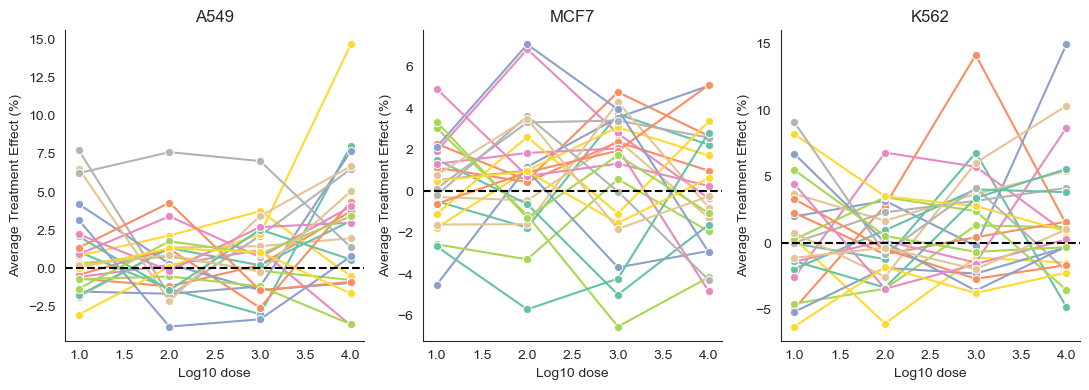

In [438]:
# Below we plot the percent difference in the fraction of cells expressing HDAC1 relative to control
# Each line represents a particular drug perturbation
fig, ax = plt.subplots(1, 3, figsize=(11, 4))
plot_drug_effect(ax[0], hdac1_df, 'A549', thresh=0, include_legend=False)
plot_drug_effect(ax[1], hdac1_df, 'MCF7', thresh=0, include_legend=False)
plot_drug_effect(ax[2], hdac1_df, 'K562', thresh=0, include_legend=False)
plt.tight_layout()

/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_39377/2312163722.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


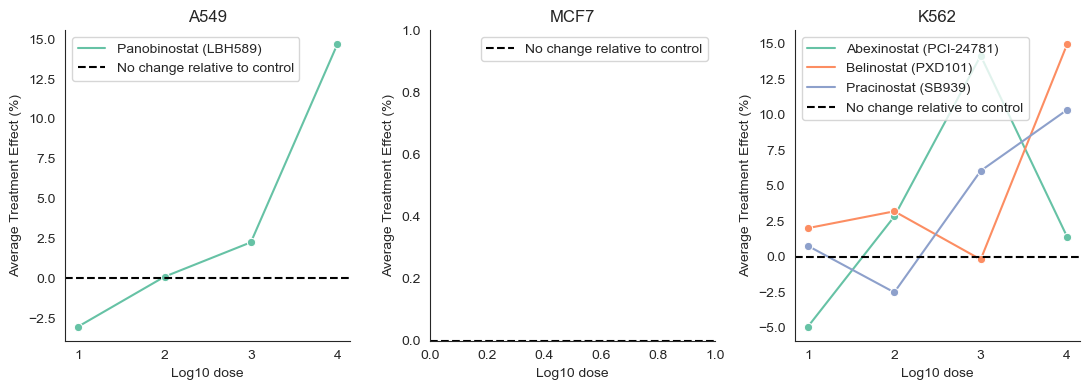

In [437]:
# Below we only plot drugs that have have at least one dosage that results in 
# at least a 10% change in the fraction of cells expressing HDAC1 relative to control
# Here MCF7 cells do not have any such drug targets
fig, ax = plt.subplots(1, 3, figsize=(11, 4))
plot_drug_effect(ax[0], hdac1_df, 'A549', thresh=10, include_legend=True)
plot_drug_effect(ax[1], hdac1_df, 'MCF7', thresh=10, include_legend=True)
plot_drug_effect(ax[2], hdac1_df, 'K562', thresh=10, include_legend=True)
plt.tight_layout()

### Zero inflated poisson regression model

In the plots above, we did not control for technical covariates (e.g., such as which plate the cell was place in, replicate number, etc.), nor did we leverage the dependence structure in the data. We also made the response binary (expresses gene or not) instead of leveraging the actual expression magnitudes.

In [429]:
class SingleCellTypeGeneExpressionModel(pyro.nn.PyroModule):
    def __init__(self, num_genes: int, num_feats: int):
        super().__init__()
        self.num_genes = num_genes
        self.num_feats = num_feats

    def forward(self, X: torch.tensor, Y: torch.tensor, theta_global: torch.tensor):
        assert X.shape[1] == self.num_feats
        assert Y.shape[1] == self.num_genes
        with pyro.plate("cells", X.shape[0]):
            with pyro.plate("genes", self.num_genes):    
                intercept = pyro.sample("intercept", dist.Normal(0, 1).expand((self.num_genes,)).to_event(1)) # G x 1
                theta_local = pyro.sample("theta_local", dist.Normal(0, 1).expand((self.num_feats, self.num_genes)).to_event(1)) # F x G
                theta = pyro.deterministic("theta", theta_local + theta_global) # F x G
                mean = intercept + torch.matmul(X, theta) # N x G
                # TODO: make this a function of technical covariates
                dropout_logits = pyro.sample("dropout_logits", dist.Normal(0, 1).expand((self.num_genes,)).to_event(1))
                # Expand to N x G
                dropout_logits = dropout_logits.expand((X.shape[0], self.num_genes))
                pyro.sample("Y", dist.ZeroInflatedPoisson(rate=torch.exp(mean), gate_logits=dropout_logits), obs=Y)


class MultiCellTypeGeneExpressionModel(pyro.nn.PyroModule):
    def __init__(self, num_genes: int, num_feats: int, num_cell_types: int):
        super().__init__()
        self.num_genes = num_genes
        self.num_feats = num_feats
        self.num_cell_types = num_cell_types
        self.cell_type_models = [SingleCellTypeGeneExpressionModel(num_genes, num_feats) for _ in range(num_cell_types)]

    def forward(self, X_types: List[torch.tensor], Y_types: List[torch.tensor]):
        assert len(X_types) == self.num_cell_types
        assert len(Y_types) == self.num_cell_types
        theta_global = pyro.sample("theta_global", dist.Normal(0, 1).expand((self.num_feats,)).to_event(1))
        for i in pyro.plate('cell_types', self.num_cell_types):
            self.cell_type_models[i](X_types[i], Y_types[i], theta_global)

In [433]:
# Make data matrices
X_categorical = pd.get_dummies(hdac_data.obs[['replicate', 'culture_plate']], dtype=np.int32).reset_index(drop=True)

# For each drug, input log dose as a feature
X_dose = pd.get_dummies(hdac_data.obs[['product_name']], dtype=np.int32).reset_index(drop=True)
X_dose = X_dose.mul(np.log10(hdac_data.obs['dose'].values + 1), axis=0)

# Combine the two feature matrices
X_hdac = torch.tensor(pd.concat([X_categorical, X_dose], axis=1).values, dtype=torch.float32)

# Get response for all gene expressions in HDAC pathway
Y_hdac = torch.tensor(hdac_data.X.toarray(), dtype=torch.float32)

In [434]:
# Segment data by cell type
A549_mask = torch.tensor((hdac_data.obs['cell_type'] == 'A549').values)
K562_mask = torch.tensor((hdac_data.obs['cell_type'] == 'K562').values)
MCF7_mask = torch.tensor((hdac_data.obs['cell_type'] == 'MCF7').values)

X_types = [X_hdac[A549_mask], X_hdac[MCF7_mask], X_hdac[K562_mask]]
Y_types = [Y_hdac[A549_mask], Y_hdac[MCF7_mask], Y_hdac[K562_mask]]

In [440]:
# Render model
model = MultiCellTypeGeneExpressionModel(num_genes=Y_hdac.shape[1], num_feats=X_hdac.shape[1], num_cell_types=3)

# Visualize model
pyro.render_model(model(X_types, Y_types), render_params=True, render_distributions=True)    

ValueError: Shape mismatch inside plate('cells') at site theta_local dim -1, 22275 vs 74

# References

1. https://www.science.org/doi/10.1126/science.aax6234
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3056563/#:~:text=Histone%20deacetylase%20(HDAC)%20inhibitors%20are,cycle%20arrest%20in%20cancer%20cells.
3. https://www.frontiersin.org/articles/10.3389/fcell.2020.576946/full
4. https://www.genenames.org/data/genegroup/#!/group/937